# Clasificación de texto usando LSTMs con TensorFlow 2.0

Vamos a crear una Red Neuronal Recurrente (BiLSTM) capaz de clasificar si una secuencia de una novela pertenece a Benito Pérez Galdós o Emilia Pardo Bazán.
 - Idea y preparación del dataset de [Javier de La Rosa](https://twitter.com/versae)

## Importamos las bibliotecas requeridas

In [ ]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import requests
print(tf.__version__)

2.8.0


## Descarga del dataset

Descargaremos 3 novelas por autor

In [ ]:
URLS = [
    ("galdos", "http://www.gutenberg.org/cache/epub/52392/pg52392.txt"),  # Miau
    ("galdos", "http://www.gutenberg.org/cache/epub/15725/pg15725.txt"),  # Doña Perfecta
    ("galdos", "http://www.gutenberg.org/cache/epub/17013/pg17013.txt"),  # Fortunata y Jacinta
    ("bazan", "https://www.gutenberg.org/files/65632/65632-0.txt"),  # La prueba
    ("bazan", "https://www.gutenberg.org/files/58059/58059-0.txt"),  # La Madre Naturaleza
    ("bazan", "https://www.gutenberg.org/cache/epub/17491/pg17491.txt"),  # La Tribuna
]

galdos = ""
bazan = ""
for author, url in tqdm(URLS):
    work_text = requests.get(url).text
    start_mark = "START OF "
    end_mark = "END OF "
    work_text = work_text[work_text.index(start_mark):work_text.index(end_mark)]
    if author == "galdos":
        galdos += "\n" + work_text
    else:
        bazan += "\n" + work_text

100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Vamos a dividir las novelas en secuencias de una longitud de 250 palabras. Podemos probar con una longitud superior e inferior. Al fin y al cabo es un parámetro a tener en cuenta cuando se define una RNN

In [ ]:
n = 250

galdos_splits = galdos.split()
galdos_chunks = [galdos_splits[i:i + n] for i in range(0, len(galdos_splits), n)]

bazan_splits = bazan.split()
bazan_chunks = [bazan_splits[i:i + n] for i in range(0, len(bazan_splits), n)]

Ahora construiremos una tabla (`DataFrame`) con los textos de cada extracto y una segunda columna indicando si pertenecen la obra de Galdós con un 1 o de Pardo Bazán con un 0.

In [ ]:
galdos_len = len(galdos_chunks)
bazan_len = len(bazan_chunks)
galdos_len, bazan_len 

(2426, 868)

In [ ]:
galdos_df = pd.DataFrame(
    [" ".join(chunk) for chunk in galdos_chunks],
    columns=["text"]
).assign(labels=1).sample(frac=1).reset_index(drop=True)

bazan_df = pd.DataFrame(
    [" ".join(chunk) for chunk in bazan_chunks],
    columns=["text"]
).assign(labels=0).sample(frac=1).reset_index(drop=True)

In [ ]:
galdos_df

,text,labels
0,"prophet. =profundo= deep, profound, abysmal; _...",1
1,sonrisa con que su primo acogiera tan extraña ...,1
2,la inocencia. --Me voy. No deje usted de pasar...,1
3,que casi se tocaban cara con cara. «Fortunata....,1
4,cuando de ella esté completamente desligada su...,1
...,...,...
2421,"distancia, a un hombre que salía de la casa. E...",1
2422,"antiespasmódica. La he hecho yo mismo, y traig...",1
2423,la estudiada actitud bonachona y festiva. Lueg...,1
2424,las diez--dijo Villalonga--. Fui al Casino a l...,1


In [ ]:
bazan_df

,text,labels
0,"sus imágenes predilectas, una Nuestra Señora d...",0
1,de las piedras... Se le ha de acordar cada vez...,0
2,las diez y seis primeritas fui yo que aquí tra...,0
3,"tranvÃ­a de Atocha, acerqueme a ella con rapid...",0
4,"seÃ±or, todo eso es Ã³ptimo, y muy meritorio y...",0
...,...,...
863,"que no corren, que vuelven al punto Ã¡ sumirse...",0
864,"huertos, o en el desierto camino del cerro de ...",0
865,nombres siquiera! Toma mi consejo. Insisto en ...,0
866,hermosura de Manolita. Â¡Manolita! Manolita sÃ...,0


## División de los datasets

In [ ]:
train_df = pd.concat(
    [galdos_df[:int(galdos_len*.2)], bazan_df[:int(bazan_len*.2)]],
    ignore_index=True
).sample(frac=1).reset_index(drop=True)

train_df

,text,labels
0,sus quejas acaloran a los descontentos y azuza...,1
1,"no se mostró enojada, sino antes bien gozosa, ...",1
2,Porque ahora sus baterÃ­as se dirigen Ã¡ que d...,0
3,de petróleo. A las niñas que debían salir al p...,1
4,"Como antes se ha dicho, a los pocos días de la...",1
...,...,...
653,suponÃ­a no sosiego; les dejarÃ­a campando en ...,0
654,ahora mismo...». Sus manos revolvieron temblor...,1
655,danzas_ que podían costarle caras. Dígase lo q...,1
656,las teclas como si las quisiera castigar por a...,1


In [ ]:
eval_df = pd.concat(
    [galdos_df[int(galdos_len*.8):], bazan_df[int(bazan_len*.8):]],
    ignore_index=True
).sample(frac=1).reset_index(drop=True)

eval_df

,text,labels
0,"su diploma, pero no colocado todavÃ­a, no se h...",0
1,"la cara de Pantoja, la de Cucúrbitas y la del ...",1
2,si sé yo hacer las cosas y me intereso por ti-...,1
3,"su domicilio. El ser _todas de piedra_, desde ...",1
4,penachillo de espuma que Ã¡ cada losa ponÃ­a e...,0
...,...,...
655,guardarlo con llave en un baúl lleno de cosas ...,1
656,"alegre, cómoda y de un aseo sorprendente. Fina...",1
657,"las redondeces futuras apuntaban ya, tenÃ­a al...",0
658,"revoloteÃ³ un momento, diÃ³ contra los cristal...",0


In [ ]:
train_df['labels'].value_counts()

1    485
0    173
Name: labels, dtype: int64

In [ ]:
eval_df['labels'].value_counts()

1    486
0    174
Name: labels, dtype: int64

## Definimos algunos parámetros de la red

 - vocab_size = cómo de largo queremos que sea nuestro vocabulario. Si es demasiado corto, el rendimiento de la red sería muy pobre pues habría muchos tokens desconocidos. Si es demasiado grande, nuestra red tardará más en entrenar.

 - embedding_dim: Este parámetro nos dice cómo de grandes queremos que sean los vectores que representan cada palabra de nuestro vocabulario. Normalmente, cuanto más grandes sean, mayor 'calidad' en la representación de las mismas.

 - max_length: Debemos definir una longitud máxima de secuencia puesto que nuestra red espera que todas tenga la misma longitud. En nuestro caso, como partimos el dataset en secuencias de 250 palabras, usaremos ese valor.

 - trunc_type: si una secuencia es más larga de 250 palabras la cortamos por detrás (post).

- padding_type = nos dice que en caso de que la secuencia se más corta de 250 tokens en qué parte de ésta se añade los tokens de padding (post = al final).

- oov_tok = `<OOV>` da un valor a las palabras/tokens que estén fuera de esas 5000 como máximo que hemos definido para nuestro vocabulario.


In [ ]:
vocab_size = 5000
embedding_dim = 64
max_length = 250
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [ ]:
train_articles = train_df['text'].tolist()
train_labels = train_df['labels'].tolist()

validation_articles = eval_df['text'].tolist()
validation_labels = eval_df['labels'].tolist()

print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

658
658
660
660


## Creamos el Tokenizer

Le vamos a decir cuál es el número máximo de palabras, el token para palabras que no estén en el vocabulario y que las pase minúsculas para reducir el tamaño del mismo

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok, lower=True)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'a': 7,
 'de': 2,
 'el': 6,
 'en': 8,
 'la': 4,
 'no': 9,
 'que': 3,
 'se': 10,
 'y': 5}

No hemos filtrado las `STOPWORDS` pero se podría.

Tokenizamos nuestro dataset de entrenamiento una vez que ya tenemos nuestro vocabulario listo.

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[10])

[4481, 91, 867, 9, 159, 48, 1, 52, 1, 1, 231, 7, 503, 5, 568, 427, 57, 25, 6, 1, 427, 4, 1, 3, 1, 1, 503, 14, 1, 2, 4, 873, 5, 460, 1, 1, 31, 2042, 3, 128, 1, 17, 316, 23, 3, 10, 3441, 2, 330, 22, 1, 2, 4, 1137, 5, 3, 15, 37, 1, 3, 4482, 14, 3, 17, 2784, 9, 1, 645, 1, 178, 7, 3442, 7, 4, 160, 375, 231, 80, 2007, 829, 4483, 47, 2, 4, 131, 216, 830, 1138, 11, 1, 359, 2331, 352, 4, 3, 10, 1, 8, 353, 1214, 4, 131, 216, 3443, 3444, 925, 14, 1788, 917, 1, 15, 4, 2785, 1, 2, 35, 1, 1, 8, 1595, 3445, 1, 4, 257, 2, 12, 2361, 309, 4484, 1, 5, 4485, 277, 4486, 1, 1, 253, 8, 17, 27, 4487, 5, 70, 14, 1, 6, 708, 21, 1, 21, 4488, 1, 3446, 231, 10, 1596, 389, 4, 47, 2, 12, 1, 31, 1789, 2, 162, 3447, 11, 60, 1, 2043, 37, 1, 5, 160, 1, 8, 4, 122, 10, 1, 4, 117, 2, 3448, 21, 1, 5, 91, 6, 623, 5, 4, 1323, 1, 10, 2786, 49, 1, 49, 1, 2, 16, 1438, 622, 4489, 49, 2362, 7, 12, 4490, 49, 1, 21, 743, 2, 35, 1, 1, 3, 4, 873, 477, 4491, 1, 8, 4, 366, 5, 1, 1, 2, 1, 1790, 478, 3, 15, 27, 3, 10, 1, 161, 22, 444, 21,

Aplicamos padding a nuestras secuencias de entrenamientoi para que todas tengan la misma longitud (para este dataset no es neceario porque las dividimos con la misma longitud, pero en otros casos suele ser útil).

In [ ]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

253
250
251
250
252
250


In [ ]:
print(train_padded[10])

[4481   91  867    9  159   48    1   52    1    1  231    7  503    5
  568  427   57   25    6    1  427    4    1    3    1    1  503   14
    1    2    4  873    5  460    1    1   31 2042    3  128    1   17
  316   23    3   10 3441    2  330   22    1    2    4 1137    5    3
   15   37    1    3 4482   14    3   17 2784    9    1  645    1  178
    7 3442    7    4  160  375  231   80 2007  829 4483   47    2    4
  131  216  830 1138   11    1  359 2331  352    4    3   10    1    8
  353 1214    4  131  216 3443 3444  925   14 1788  917    1   15    4
 2785    1    2   35    1    1    8 1595 3445    1    4  257    2   12
 2361  309 4484    1    5 4485  277 4486    1    1  253    8   17   27
 4487    5   70   14    1    6  708   21    1   21 4488    1 3446  231
   10 1596  389    4   47    2   12    1   31 1789    2  162 3447   11
   60    1 2043   37    1    5  160    1    8    4  122   10    1    4
  117    2 3448   21    1    5   91    6  623    5    4 1323    1   10
 2786 

Hacemos lo propio con el dataset de validación

In [ ]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

660
(660, 250)


Codificamos correctamente las `labels`

In [ ]:
training_label_seq = np.array(train_labels, dtype=np.int8)
validation_label_seq = np.array(validation_labels, dtype=np.int8)
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

1
1
0
(658,)
0
1
1
(660,)


Veamos cómo somos capaces de decodificar una secuencia tokenizada a texto de nuevo gracias al tokenizer que creamos

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(train_articles[10])

cantando entre dientes no sé qué <OOV> o <OOV> <OOV> amparo a baltasar y echó tras él como el <OOV> tras la <OOV> que <OOV> <OOV> baltasar las <OOV> de la tribuna y pudo <OOV> <OOV> era solamente que iba <OOV> lo cierto es que se perdió de vista al <OOV> de la esquina y que por muy <OOV> que anduvieron las que lo seguían no <OOV> darle <OOV> voy a llamarle a la puerta exclamó amparo mujer ¿estás loca ¡una casa de la calle mayor murmuró ana con <OOV> miedo ¿tú sabes la que se <OOV> en horas semejantes la calle mayor ofrecía imponente aspecto las altas casas <OOV> por la brillante <OOV> de sus <OOV> <OOV> en cuyos vidrios <OOV> la luz de los faroles estaban cerradas <OOV> y serias algún lejano <OOV> <OOV> allá en lo más remoto y sobre las <OOV> el golpe del <OOV> del sereno <OOV> majestuoso amparo se detuvo ante la casa de los <OOV> era ésta de tres pisos con dos <OOV> blancas muy <OOV> y puerta <OOV> en la cual se <OOV> la mano de bronce del <OOV> y entre el silencio y la calma <OOV> se

## Construimos nuestra red neuronal

- Utilizaremos la `Sequential` API de Keras
- Creamos una primera capa de `Embedding`que tiene por tamaño `vocab_size`x `embedding_dim`
- Despues añadimos nuestra capa de recurrencia. En este caso será una `LSTM` bidireccional (aprende de izquerida a derecha y de derecha a izquierda)
- Conectamos la salida de esa capa a una capa `Dense`.
- Por último, conectamos todo a una capa `Dense`con función de activación `sigmoid`ya que nuestro problema de clasificación es binario.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 394,369
Trainable params: 394,369
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Entrenamos nuestro modelo

In [ ]:
num_epochs = 4
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/4
21/21 - 5s - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.2463 - val_accuracy: 0.9212 - 5s/epoch - 252ms/step
Epoch 2/4
21/21 - 8s - loss: 3.9817e-04 - accuracy: 1.0000 - val_loss: 0.3010 - val_accuracy: 0.9197 - 8s/epoch - 371ms/step
Epoch 3/4
21/21 - 6s - loss: 1.4113e-04 - accuracy: 1.0000 - val_loss: 0.2337 - val_accuracy: 0.9303 - 6s/epoch - 305ms/step
Epoch 4/4
21/21 - 4s - loss: 1.0493e-04 - accuracy: 1.0000 - val_loss: 0.2410 - val_accuracy: 0.9318 - 4s/epoch - 212ms/step


## Visualizamos los resultados

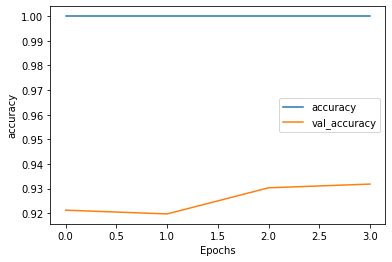

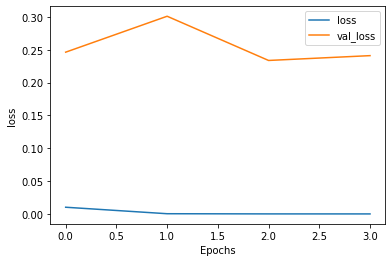

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Probemos nuestro modelo

In [ ]:
validation_articles[50], validation_label_seq[50]

('si por acaso... Quita, quita, pensamiento y no me tientes con una sospecha, que parece tan verosímil... El mismo Feijoo quizás... puede... habrá tenido... y ahora... Sobre esto quiero echar tierra, porque me volvería loca. La verdad es que el pobre señor ha dado un bajón tremendo y no debe de haber estado para morisquetas de algunos meses acá. ¡Si será cierto lo que dice!... ¡Caridad, lástima, arrepentimiento... necesidad de transigir, decoro, reconciliación...!». Otro inciso. Miró a la calle y vio por segunda vez a Guillermina que subía. «¿Pero qué trae en la mano?, un palo y un garfio de hierro. ¡Vaya con la santa esta! Algo que le han dado. Dicen que lo acepta todo. Véase por dónde yo le podría ayudar a su obra, dándole media docena de llaves viejas que tengo aquí. Aquella tabla que lleva parece una plantilla... Toma, como que vendrá del almacén de maderas de la calle de Valencia. Vaya unos trajines... Vea usted una cosa que a mí me gustaría, edificar un _establecimiento_, pidiénd

In [ ]:
txt = ['''la terquedad de que todas las personas de la familia se confabulaban contra él para atormentarle''']

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
print(pred)
print("Parece una secuencia de una novela de Galdós" if pred[0] > 0.5 else "Parece que esta novela pertenece a Emilia Pardo Bazán")

[[0.9653466]]
Parece una secuencia de una novela de Galdós
